# Exploring Contextural Bias of ResNet50 on CIFAR10 Dataset

### Introduction

This notebook trains and tests a vanilla ResNet50 model and a stylised ResNet50 model with the CIFAR10 dataset. It includes functions for loading the dataset, turning them into tensors, model training and testing.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Conv2d, AvgPool2d
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from skimage import io
import numpy as np
from PIL import Image

### Data Loading

The following cell provides a class that loads the CIFAR dataset given the relevant path, processes it into a dictionary format of class labels and content then processes the images into tensors. The class also has helper functions to extract information about the dataset needed for model training and testing.

In [2]:
class CifarDataset(Dataset):
    
    def __init__(self, data_path):
        
        super(CifarDataset, self).__init__()
        self.data_path = data_path
        self.num_classes = 0
        self.classes = []
        
        classes_list = []
        for class_name in os.listdir(data_path):
            if not os.path.isdir(os.path.join(data_path,class_name)):
                continue
            classes_list.append(class_name)
        classes_list.sort()
        self.classes = [dict(class_idx = k, class_name = v) for k, v in enumerate(classes_list)]
        

        self.num_classes = len(self.classes)

        self.image_list = []
        for cls in self.classes:
            class_path = os.path.join(data_path, cls['class_name'])
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_list.append(dict(
                    cls = cls,
                    image_path = image_path,
                    image_name = image_name,
                ))

        self.img_idxes = np.arange(0,len(self.image_list))

    def __len__(self):
        return len(self.img_idxes)

    def __getitem__(self, index):

        img_idx = self.img_idxes[index]
        img_info = self.image_list[img_idx]

        img = Image.open(img_info['image_path'])

        tr = transforms.ToTensor()
        img = tr(img)
        tr = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        img = tr(img)
        return dict(image = img, cls = img_info['cls']['class_idx'], class_name = img_info['cls']['class_name'])

    def get_number_of_classes(self):
        return self.num_classes

    def get_number_of_samples(self):
        return self.__len__()

    def get_class_names(self):
        return [cls['class_name'] for cls in self.classes]

    def get_class_name(self, class_idx):
        return self.classes[class_idx]['class_name']

In [3]:
def get_cifar_datasets(data_path):
    dataset = CifarDataset(data_path)
    return dataset

The data being used for this experiment are normal CIFAR10 dataset and the stylised version of the CIFAR10 dataset created using AdaIN style transfer.

The following cell calls the function created above to load the training, validation and testing datasets of both normal and stylised CIFAR10 and transforms them into data loaders.

In [4]:
# Load normal CIFAR10
data_path_train = "../../CIFAR/cifar32/training"
dataset_train = get_cifar_datasets(data_path_train)

data_path_val = "../../CIFAR/cifar32/validation/"
dataset_val = get_cifar_datasets(data_path_val)

data_path_test = "../../CIFAR/cifar32/testing/"
dataset_test = get_cifar_datasets(data_path_test)

print(f"Number of train samples {dataset_train.__len__()}")
print("Class names are: " + str(dataset_train.get_class_names()))

print(f"Number of val samples {dataset_val.__len__()}")
print("Class names are: " + str(dataset_val.get_class_names()))

print(f"Number of test samples {dataset_test.__len__()}")
print("Class names are: " + str(dataset_test.get_class_names()))

BATCH_SIZE = 64

data_loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True)
data_loader_val = DataLoader(dataset_val, BATCH_SIZE, shuffle = True)
data_loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = True)

Number of train samples 36000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of val samples 4000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of test samples 10000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']


In [5]:
# Load stylised CIFAR10 with original kaggle images
data_path_train_style = "../../CIFAR/cifar32_style/training"
dataset_train_style = get_cifar_datasets(data_path_train_style)

data_path_val_style = "../../CIFAR/cifar32_style/validation/"
dataset_val_style = get_cifar_datasets(data_path_val_style)

data_path_test_style = "../../CIFAR/cifar32_style/testing/"
dataset_test_style = get_cifar_datasets(data_path_test_style)

print(f"Number of stylised train samples {dataset_train_style.__len__()}")
print("Class names are: " + str(dataset_train_style.get_class_names()))

print(f"Number of stylised val samples {dataset_val_style.__len__()}")
print("Class names are: " + str(dataset_val_style.get_class_names()))

print(f"Number of stylised test samples {dataset_test_style.__len__()}")
print("Class names are: " + str(dataset_test_style.get_class_names()))

BATCH_SIZE = 64

data_loader_train_style = DataLoader(dataset_train_style, BATCH_SIZE, shuffle = True)
data_loader_val_style = DataLoader(dataset_val_style, BATCH_SIZE, shuffle = True)
data_loader_test_style = DataLoader(dataset_test_style, BATCH_SIZE, shuffle = True)

Number of stylised train samples 216000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of stylised val samples 4000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of stylised test samples 10000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']


In [6]:
# Load stylised CIFAR10 with reduced kaggle images
data_path_train_style_red = "../../CIFAR/cifar32_style_red/training"
dataset_train_style_red = get_cifar_datasets(data_path_train_style_red)

data_path_val_style_red = "../../CIFAR/cifar32_style_red/validation/"
dataset_val_style_red = get_cifar_datasets(data_path_val_style_red)

data_path_test_style_red = "../../CIFAR/cifar32_style_red/testing/"
dataset_test_style_red = get_cifar_datasets(data_path_test_style_red)

print(f"Number of reduced stylised train samples {dataset_train_style_red.__len__()}")
print("Class names are: " + str(dataset_train_style_red.get_class_names()))

print(f"Number of reduced stylised val samples {dataset_val_style_red.__len__()}")
print("Class names are: " + str(dataset_val_style_red.get_class_names()))

print(f"Number of reduced stylised test samples {dataset_test_style_red.__len__()}")
print("Class names are: " + str(dataset_test_style_red.get_class_names()))

BATCH_SIZE = 64

data_loader_train_style_red = DataLoader(dataset_train_style_red, BATCH_SIZE, shuffle = True)
data_loader_val_style_red = DataLoader(dataset_val_style_red, BATCH_SIZE, shuffle = True)
data_loader_test_style_red = DataLoader(dataset_test_style_red, BATCH_SIZE, shuffle = True)

Number of reduced stylised train samples 216000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of reduced stylised val samples 4000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']
Number of reduced stylised test samples 10000
Class names are: ['0000000001', '0000000010', '0000000100', '0000001000', '0000010000', '0000100000', '0001000000', '0010000000', '0100000000', '1000000000']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Shape of batch['image'] torch.Size([64, 3, 32, 32])
Shape of batch['cls'] torch.Size([64])


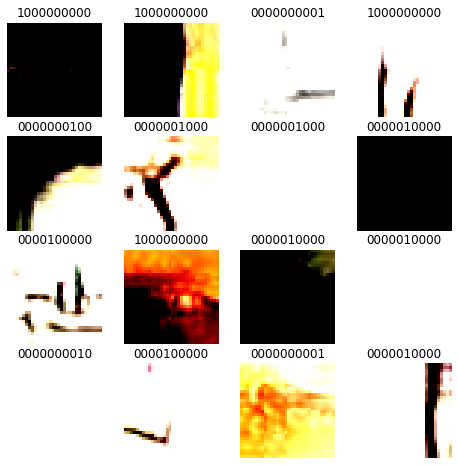

In [7]:
# TODO: Delete before submission
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4,4, figsize=(8, 8))

for batch in data_loader_train_style:

    print(f"Shape of batch['image'] {batch['image'].shape}")
    print(f"Shape of batch['cls'] {batch['cls'].shape}")

    for i in range(BATCH_SIZE):
        col = i % 4
        row = i // 4

        img = batch['image'][i].numpy()

        axes[row,col].set_axis_off()
        axes[row,col].set_title(batch['class_name'][i])
        axes[row,col].imshow(np.transpose(img,(1,2,0)))
                         
        if i >= 15:
            break

    plt.show()
    break

### Defining ResNet50

The following code defines Resnet50 architecture that will be used to train and test the CIFAR dataset.

In [8]:
# define resnet building blocks
class ResidualBlock(nn.Module): 
    expansion = 4
    
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(
            Conv2d(inchannel, outchannel, kernel_size=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            Conv2d(outchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            Conv2d(outchannel, self.expansion*outchannel, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.expansion*outchannel)
        ) 
        
        self.shortcut = nn.Sequential()
        
        if stride != 1 or inchannel != self.expansion*outchannel: 
            self.shortcut = nn.Sequential(
                Conv2d(inchannel, self.expansion*outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*outchannel)
            ) 
            
    def forward(self, x): 
        out = self.left(x) 
        out += self.shortcut(x) 
        out = F.relu(out) 
        return out

    
# define resnet
class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            Conv2d(3, 64, kernel_size = 3, stride = 1,padding = 1, bias = False),
            nn.BatchNorm2d(64), 
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 3, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 4, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 6, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 3, stride = 2)
        self.avgpool = AvgPool2d(4)
        self.fc = nn.Linear(512*ResidualBlock.expansion, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels * block.expansion
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    
def ResNet50():
    return ResNet(ResidualBlock)

Following are the training, validation and testing functions for the experiment. train_part() function trains and updates gradients on each batch of the training set and once that is done, it tests its accuracy on the validation set. Every time the validation test returns a better accuracy than the current maximum, the model is saved and carries on with the next epoch. Then it checks with the learning reate scheduler for any changes in learning rate.

In [9]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for i, batch in enumerate(loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs = batch['image'].to(device)
            labels = batch['cls'].to(device)
            scores = model(inputs)
            _, preds = scores.max(1)
            num_correct += (preds == labels).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct, accuracy of the dataset is: %.3f %%' % (num_correct, num_samples, 100 * acc))


def train_part(model, train_data, val_data, model_path, optimizer, lr_scheduler, epochs=1):
    model.to(device)
    val_acc = 0
    num_epoch = 2
    # Main Loop
    for epoch in range(epochs):  # loop over the dataset multiple times
        val_loss = 0
        running_loss = 0

        # Training Loop
        for i, batch in enumerate(train_data, 0):
            # set model to training mode
            model.train()
            # get the inputs; data is a list of [inputs, labels]
            inputs = batch['image'].to(device)
            labels = batch['cls'].to(device)

            # get outputs from the input data and calculate the cross entropy loss
            scores = model(inputs)
            loss = F.cross_entropy(scores, labels)

            # zero and update the gradients and optimise
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.6f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0

        # set model to evaluation mode
        model.eval()

        # Validation Loop
        with torch.no_grad():
            num_correct = 0
            num_samples = 0
            for i, batch in enumerate(val_data, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs = batch['image'].to(device)
                labels = batch['cls'].to(device)

                # get the outputs from the model
                outputs = model(inputs)

                # compute accuracy based on the outputs
                _, preds = outputs.max(1)
                num_correct += (preds == labels).sum()
                num_samples += preds.size(0)
            acc = float(num_correct) / num_samples
            print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

            if acc > val_acc:
                print('saving model')
                torch.save(model.state_dict(), model_path)
                val_acc = acc
            else:
                print('skip model saving')
        lr_scheduler.step()

cuda:1


### Vanilla ResNet50 Training

The model used in this experiment is ResNet50 with Adam optimiser with learning rate scheduler and default settings. Learning rate changes every 80, 120, 160, 180th epoch.

In [10]:
torch.cuda.empty_cache()

# define and train the network
vanilla_model_path = './cifar32_model.pth'
vanilla_model = ResNet50()
lr=0.1
vanilla_optimizer = optim.Adam(vanilla_model.parameters(), lr=lr)
vanilla_lr_scheduler = optim.lr_scheduler.MultiStepLR(vanilla_optimizer, milestones=[100, 150, 180])
train_part(vanilla_model, data_loader_train, data_loader_val, vanilla_model_path, vanilla_optimizer, vanilla_lr_scheduler, epochs = 200)

[1,   200] loss: 4.404325
[1,   400] loss: 2.024682
Got 1102 / 4000 correct (27.55)
saving model
[2,   200] loss: 1.832623
[2,   400] loss: 1.778489
Got 1357 / 4000 correct (33.92)
saving model
[3,   200] loss: 1.682013
[3,   400] loss: 1.644374
Got 1742 / 4000 correct (43.55)
saving model
[4,   200] loss: 1.536639
[4,   400] loss: 1.519283
Got 1905 / 4000 correct (47.62)
saving model
[5,   200] loss: 1.424567
[5,   400] loss: 1.381319
Got 1950 / 4000 correct (48.75)
saving model
[6,   200] loss: 1.306095
[6,   400] loss: 1.299620
Got 2101 / 4000 correct (52.52)
saving model
[7,   200] loss: 1.238209
[7,   400] loss: 1.209562
Got 2297 / 4000 correct (57.43)
saving model
[8,   200] loss: 1.158139
[8,   400] loss: 1.128885
Got 2319 / 4000 correct (57.98)
saving model
[9,   200] loss: 1.071163
[9,   400] loss: 1.066281
Got 2395 / 4000 correct (59.88)
saving model
[10,   200] loss: 1.002524
[10,   400] loss: 0.994455
Got 2517 / 4000 correct (62.92)
saving model
[11,   200] loss: 0.939792
[

[81,   400] loss: 0.011513
Got 3207 / 4000 correct (80.17)
saving model
[82,   200] loss: 0.003996
[82,   400] loss: 0.004698
Got 3202 / 4000 correct (80.05)
skip model saving
[83,   200] loss: 0.001916
[83,   400] loss: 0.001921
Got 3212 / 4000 correct (80.30)
saving model
[84,   200] loss: 0.001840
[84,   400] loss: 0.001312
Got 3211 / 4000 correct (80.27)
skip model saving
[85,   200] loss: 0.000876
[85,   400] loss: 0.000730
Got 3226 / 4000 correct (80.65)
saving model
[86,   200] loss: 0.000743
[86,   400] loss: 0.001804
Got 3230 / 4000 correct (80.75)
saving model
[87,   200] loss: 0.000689
[87,   400] loss: 0.000952
Got 3224 / 4000 correct (80.60)
skip model saving
[88,   200] loss: 0.000429
[88,   400] loss: 0.000594
Got 3219 / 4000 correct (80.47)
skip model saving
[89,   200] loss: 0.000381
[89,   400] loss: 0.000650
Got 3216 / 4000 correct (80.40)
skip model saving
[90,   200] loss: 0.000876
[90,   400] loss: 0.000549
Got 3232 / 4000 correct (80.80)
saving model
[91,   200] 

Got 3226 / 4000 correct (80.65)
skip model saving
[160,   200] loss: 0.000016
[160,   400] loss: 0.000012
Got 3227 / 4000 correct (80.67)
skip model saving
[161,   200] loss: 0.000015
[161,   400] loss: 0.000014
Got 3231 / 4000 correct (80.77)
skip model saving
[162,   200] loss: 0.000018
[162,   400] loss: 0.000023
Got 3227 / 4000 correct (80.67)
skip model saving
[163,   200] loss: 0.000010
[163,   400] loss: 0.000017
Got 3237 / 4000 correct (80.92)
skip model saving
[164,   200] loss: 0.000008
[164,   400] loss: 0.000011
Got 3240 / 4000 correct (81.00)
skip model saving
[165,   200] loss: 0.000033
[165,   400] loss: 0.000040
Got 3232 / 4000 correct (80.80)
skip model saving
[166,   200] loss: 0.000006
[166,   400] loss: 0.000016
Got 3228 / 4000 correct (80.70)
skip model saving
[167,   200] loss: 0.000011
[167,   400] loss: 0.000013
Got 3236 / 4000 correct (80.90)
skip model saving
[168,   200] loss: 0.000013
[168,   400] loss: 0.000013
Got 3240 / 4000 correct (81.00)
skip model sav

### Testing Normal CIFAR10 on Vanilla ResNet50

The below code tests the vanilla ResNet50 model on the normal CIFAR10 test set and prints out the final accuracy of the model.

In [11]:
# report test set accuracy
vanilla_model = ResNet50()
vanilla_model.load_state_dict(torch.load('./cifar32_model.pth'))
vanilla_model.to(device)
check_accuracy(data_loader_test, vanilla_model)

Got 8124 / 10000 correct, accuracy of the dataset is: 81.240 %


### Stylised ResNet50 Training

Stylised ResNet50 training has all the same settings as vanilla ResNet50, except the data being used here are the stylised CIFAR10.

In [12]:
# torch.cuda.empty_cache()

# # define and train the network
# stylised_model_path = './cifar32_style_model.pth'
# stylised_model = ResNet50()
# lr=0.1
# stylised_optimizer = optim.Adam(stylised_model.parameters(), lr=lr)
# stylised_lr_scheduler = optim.lr_scheduler.MultiStepLR(stylised_optimizer, milestones=[80, 120, 150, 180])
# train_part(stylised_model, data_loader_train_style, data_loader_val_style, stylised_model_path, stylised_optimizer, stylised_lr_scheduler, epochs = 200)

### Testing Stylised CIFAR10 on Stylised ResNet50

The below code tests the stylised ResNet50 model on the stylised CIFAR10 test set and prints out the final accuracy of the model.

In [13]:
# # report test set accuracy
# stylised_model = ResNet50()
# stylised_model.load_state_dict(torch.load('./cifar32_style_model.pth'))
# stylised_model.to(device)
# check_accuracy(data_loader_test_style, stylised_model)

### Testing Stylised CIFAR10 on Vanilla ResNet50

The below code tests the vanilla ResNet50 model on the stylised CIFAR10 test set and prints out the final accuracy of the model.

In [14]:
# report test set accuracy
vanilla_model = ResNet50()
vanilla_model.load_state_dict(torch.load('./cifar32_model.pth'))
vanilla_model.to(device)
check_accuracy(data_loader_test_style, vanilla_model)

Got 1108 / 10000 correct, accuracy of the dataset is: 11.080 %


### Testing Vanilla CIFAR10 on Stylised ResNet50

The below code tests the stylised ResNet50 model on the vanilla CIFAR10 test set and prints out the final accuracy of the model.

In [15]:
# # report test set accuracy
# stylised_model = ResNet50()
# stylised_model.load_state_dict(torch.load('./cifar32_style_model.pth'))
# stylised_model.to(device)
# check_accuracy(data_loader_test, stylised_model)

In [16]:
# report test set accuracy
vanilla_model = ResNet50()
vanilla_model.load_state_dict(torch.load('./cifar32_model.pth'))
vanilla_model.to(device)
check_accuracy(data_loader_test_style_red, vanilla_model)

Got 1001 / 10000 correct, accuracy of the dataset is: 10.010 %
